In [ ]:
% ls

data/  drive/  sample_data/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import json
import numpy as np
import pandas as pd
import pickle
import math

import pandas as pd

import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

from sklearn.metrics import  classification_report, confusion_matrix



# Data preperation

please be aware that the format used to encode drug samples is the canonical format. If you wish to use iso format, you have to retrain the model


In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Project_data/data'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd data


Mounted at /content/drive
/content/drive/My Drive
/content
/content/data


In [4]:
dataset = 'davis'

filename = dataset + '/ligands_can.txt'

with open(filename) as f:
  ligands = json.load(f)


filename =  dataset + '/proteins.txt'

with open(filename) as f:
  proteins = json.load(f)

len(ligands), len(proteins)

(68, 442)

In [6]:
if dataset == 'davis':
  max_length_prot = 1200
  max_length_lig = 85
else:
  max_length_prot = 1000
  max_length_lig = 100


In [5]:
CHARPROTSET = { "A": 1, "C": 2, "B": 3, "E": 4, "D": 5, "G": 6, 
				"F": 7, "I": 8, "H": 9, "K": 10, "M": 11, "L": 12, 
				"O": 13, "N": 14, "Q": 15, "P": 16, "S": 17, "R": 18, 
				"U": 19, "T": 20, "W": 21, 
				"V": 22, "Y": 23, "X": 24, 
				"Z": 25 }

CHARCANSMISET = { "#": 1, "%": 2, ")": 3, "(": 4, "+": 5, "-": 6, 
			 ".": 7, "1": 8, "0": 9, "3": 10, "2": 11, "5": 12, 
			 "4": 13, "7": 14, "6": 15, "9": 16, "8": 17, "=": 18, 
			 "A": 19, "C": 20, "B": 21, "E": 22, "D": 23, "G": 24,
			 "F": 25, "I": 26, "H": 27, "K": 28, "M": 29, "L": 30, 
			 "O": 31, "N": 32, "P": 33, "S": 34, "R": 35, "U": 36, 
			 "T": 37, "W": 38, "V": 39, "Y": 40, "[": 41, "Z": 42, 
			 "]": 43, "_": 44, "a": 45, "c": 46, "b": 47, "e": 48, 
			 "d": 49, "g": 50, "f": 51, "i": 52, "h": 53, "m": 54, 
			 "l": 55, "o": 56, "n": 57, "s": 58, "r": 59, "u": 60,
			 "t": 61, "y": 62}

In [7]:
def encode_data(data, max_length, mapping):
  res = np.zeros((len(data), max_length))
  
  for i, d in enumerate(data.keys()):
    print(d)
    for w in range(min(max_length, len(data[d]))):
      res[i][w] = mapping[data[d][w]]

  return res

def encode_one_hot(data, max_length, mapping):
  charlen = len(mapping)
  res = np.zeros((len(data), max_length, charlen))
  for i, d in enumerate(data.keys()):
    print(d)
    for w in range(min(max_length, len(data[d]))):
        res[i][w][mapping[data[d][w]]] = 1
  return res

In [8]:
protein_data = encode_data(proteins, max_length_prot, CHARPROTSET)
ligand_data = encode_data(ligands, max_length_lig, CHARCANSMISET)

AAK1
ABL1(E255K)
ABL1(F317I)
ABL1(F317I)p
ABL1(F317L)
ABL1(F317L)p
ABL1(H396P)
ABL1(H396P)p
ABL1(M351T)
ABL1(Q252H)
ABL1(Q252H)p
ABL1(T315I)
ABL1(T315I)p
ABL1(Y253F)
ABL1
ABL1p
ABL2
ACVR1
ACVR1B
ACVR2A
ACVR2B
ACVRL1
ADCK3
ADCK4
AKT1
AKT2
AKT3
ALK
AMPK-alpha1
AMPK-alpha2
ANKK1
ARK5
ASK1
ASK2
AURKA
AURKB
AURKC
AXL
BIKE
BLK
BMPR1A
BMPR1B
BMPR2
BMX
BRAF
BRAF(V600E)
BRK
BRSK1
BRSK2
BTK
CAMK1
CAMK1D
CAMK1G
CAMK2A
CAMK2B
CAMK2D
CAMK2G
CAMK4
CAMKK1
CAMKK2
CASK
CDC2L1
CDC2L2
CDC2L5
CDK11
CDK2
CDK3
CDK4-cyclinD1
CDK4-cyclinD3
CDK5
CDK7
CDK8
CDK9
CDKL1
CDKL2
CDKL3
CDKL5
CHEK1
CHEK2
CIT
CLK1
CLK2
CLK3
CLK4
CSF1R
CSK
CSNK1A1
CSNK1A1L
CSNK1D
CSNK1E
CSNK1G1
CSNK1G2
CSNK1G3
CSNK2A1
CSNK2A2
CTK
DAPK1
DAPK2
DAPK3
DCAMKL1
DCAMKL2
DCAMKL3
DDR1
DDR2
DLK
DMPK
DMPK2
DRAK1
DRAK2
DYRK1A
DYRK1B
DYRK2
EGFR
EGFR(E746A750del)
EGFR(G719C)
EGFR(G719S)
EGFR(L747E749del)
EGFR(L747S752del)
EGFR(L747T751del)
EGFR(L858R)
EGFR(L858RT790M)
EGFR(L861Q)
EGFR(S752I759del)
EGFR(T790M)
EIF2AK1
EPHA1
EPHA2
EPHA3
EPHA4
EPHA5
EPHA

In [9]:
Y_path = dataset + '/Y'
with open(Y_path, 'rb') as f:
  Y = pickle.load(f, encoding='latin1')

if dataset == 'davis':
  Y = -(np.log10(Y/(math.pow(10,9))))
label_row_inds, label_col_inds = np.where(np.isnan(Y)==False)

label_row_inds.shape, label_col_inds.shape



((30056,), (30056,))

array([ 1483, 18097, 11736, ..., 21824,  1017,  8671])

In [10]:
test_indices = json.load(open(dataset + "/folds/test_fold_setting1.txt"))
train_indices = json.load(open(dataset + "/folds/train_fold_setting1.txt"))


test_drug_indices = label_row_inds[test_indices]
test_protein_indices = label_col_inds[test_indices]

train_indices = np.concatenate([train_indices[0], train_indices[1], train_indices[2], train_indices[3], train_indices[4]])

train_indices = np.array(train_indices).flatten()


train_drug_indices = label_row_inds[train_indices]
train_protein_indices = label_col_inds[train_indices]

test_drug_indices.shape, train_drug_indices.shape

np.unique(label_row_inds, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 array([442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442,
        442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442,
        442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442,
        442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442,
        442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442,
        442, 442, 442]))

In [11]:
train_drug_X = ligand_data[train_drug_indices]
train_prot_X = protein_data[train_protein_indices]

train_Y = Y[train_drug_indices, train_protein_indices]

test_drug_X = ligand_data[test_drug_indices]
test_prot_X = protein_data[test_protein_indices]

test_Y = Y[test_drug_indices, test_protein_indices]

train_Y.shape, train_drug_X.shape, train_prot_X.shape, test_Y.shape, test_drug_X.shape, test_prot_X.shape

((25046,), (25046, 85), (25046, 1200), (5010,), (5010, 85), (5010, 1200))

# Model

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [13]:
class DTADataset(Dataset):
  def __init__(self, X_ligand, X_prot, y):
    self.X_ligand = torch.tensor(X_ligand)
    self.X_prot = torch.tensor(X_prot)
    self.y = torch.tensor(y)
  def __getitem__(self, index):
     if torch.is_tensor(index):
            index = index.tolist()
     return  self.X_ligand[index], self.X_prot[index], self.y[index]
  def __len__(self):
    return self.X_ligand.shape[0]



In [14]:
trainset = DTADataset(train_drug_X, train_prot_X, train_Y)
testset = DTADataset(test_drug_X, test_prot_X, test_Y)




BATCH_SIZE = 256

trainloader = DataLoader(dataset = trainset,
                          batch_size = BATCH_SIZE,
                          shuffle=True)


testloader = DataLoader(dataset = testset,
                          batch_size = BATCH_SIZE,
                          shuffle=True)

In [26]:
class DrugProtLSTM(nn.Module):
     def __init__(self, hidden_dim, charlen, embedding_dim):
        super().__init__()
        

        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(charlen, embedding_dim)

        self.LSTM = nn.LSTM(embedding_dim, hidden_dim, 1, batch_first = True)

        self.fc1 = nn.Linear(hidden_dim, 256)
        self.relu = nn.ReLU()

     def forward(self, x):
          x_e = self.embedding(x)

          lstm_out, h = self.LSTM(x_e)

          x = h[0][-1].view(-1, self.hidden_dim)

          x = self.fc1(x)
          x = self.relu(x)


          return x
        


In [27]:
class DrugModel(nn.Module):
   def __init__(self, charlen, embedding_dim, num_filters, druglen):
        super().__init__()
        self.embedding = nn.Embedding(charlen, embedding_dim)

        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=4)
        self.conv2 = nn.Conv1d(num_filters, num_filters * 2, kernel_size=6)
        self.conv3 = nn.Conv1d(num_filters * 2, num_filters * 3, kernel_size=8)

        """self.fc1 = nn.Linear(((signal_len - 15) // 3) * num_filters * 3, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 1)"""

        self.maxpooling = nn.MaxPool1d(druglen - 15)

        self.relu = nn.ReLU()


   def forward(self, x):
      x_e = self.embedding(x)
      x = torch.transpose(x_e, 1, 2)

      x = self.conv1(x)
      x = self.relu(x)

      x = self.conv2(x)
      x = self.relu(x)

      x = self.conv3(x)
      x = self.relu(x)
      y = x

      x = self.maxpooling(x)

      """x = torch.flatten(x, 1)

      x = self.fc1(x)
      x = self.relu(x)
    
      x = F.dropout(x, p=0.1, training=self.training)

      x = self.fc2(x)
      x = self.relu(x)

      x = F.dropout(x, p = 0.1, training=self.training)

      x = self.fc3(x)
      x = self.relu(x)

      x = self.fc4(x)"""

      return x


In [28]:
class DrugProtModel(nn.Module):
   def __init__(self, charlen, embedding_dim, num_filters):
        super().__init__()
        self.embedding = nn.Embedding(charlen, embedding_dim)

        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=4)
        self.conv2 = nn.Conv1d(num_filters, num_filters * 2, kernel_size=6)
        self.conv3 = nn.Conv1d(num_filters * 2, num_filters * 3, kernel_size=8)

        """self.fc1 = nn.Linear(((signal_len - 15) // 3) * num_filters * 3, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 1)"""

        self.maxpooling = nn.MaxPool1d(3)

        self.relu = nn.ReLU()


   def forward(self, x):
      x_e = self.embedding(x)
      x = torch.transpose(x_e, 1, 2)

      x = self.conv1(x)
      x = self.relu(x)

      x = self.conv2(x)
      x = self.relu(x)

      x = self.conv3(x)
      x = self.relu(x)

      x = self.maxpooling(x)

      """x = torch.flatten(x, 1)

      x = self.fc1(x)
      x = self.relu(x)
    
      x = F.dropout(x, p=0.1, training=self.training)

      x = self.fc2(x)
      x = self.relu(x)

      x = F.dropout(x, p = 0.1, training=self.training)

      x = self.fc3(x)
      x = self.relu(x)

      x = self.fc4(x)"""

      return x


In [29]:
class DTAModel(nn.Module):
     def __init__(self, druglen, protlen):
       super().__init__()
       self.drugmodel = DrugModel(62, 128, 32, druglen)
       #self.protmodel = DrugProtModel(25, 128, 32)
       self.lstm_model = DrugProtLSTM(256, 25, 128)
       self.fc1 = nn.Linear(96 * (((druglen - 15) // 3) + ((protlen - 15) // 3)), 1024)
       self.fc_lstm = nn.Linear(96 + 256, 1024)
       self.fc2 = nn.Linear(1024, 1024)
       self.fc3 = nn.Linear(1024, 512)
       self.fc4=  nn.Linear(512, 1)

       self.relu = nn.ReLU()
    

     def forward(self, drug, prot):
        drug_rep = self.drugmodel(drug)
        drug_rep = drug_rep.squeeze(2)
        #prot_rep = self.protmodel(prot)
        prot_rep = self.lstm_model(prot)

        x = torch.cat([drug_rep, prot_rep], 1)

        x = torch.flatten(x, 1)

        #x = self.fc1(x)
        x=  self.fc_lstm(x)
        x = self.relu(x)

        x = F.dropout(x, p = 0.2, training=self.training)

        
        x = self.fc2(x)
        x = self.relu(x)

        x = F.dropout(x, p = 0.2, training=self.training)

        
        x = self.fc3(x)
        x = self.relu(x)

        x = F.dropout(x, p = 0.1, training=self.training)

        x = self.fc4(x)

        return x



In [33]:
LOG_INTERVAL = 30
def train(model, optimizer, loss_function, verbose = True):
  model.train()
  train_loss = 0

  for batch_idx, data in enumerate(tqdm(trainloader, desc='Batches', leave=False)):
    drug, prot, binding = data[0].long().to(device), data[1].long().to(device), data[2].unsqueeze(1).to(device).float()
    optimizer.zero_grad()

    o = model(drug, prot)

    loss = loss_function(o, binding)

    train_loss += loss.item()

    loss.backward()
    optimizer.step()
    if verbose and batch_idx % LOG_INTERVAL == LOG_INTERVAL-1:
          print('    Train [%d/%d]\t | \tLoss: %.5f' % (batch_idx * drug.shape[0], len(trainloader.dataset), loss.item() / drug.shape[0]))
  train_loss /= len(trainloader.dataset)
  if verbose:
      print('==> Train | Average loss: %.4f' % train_loss)
  return train_loss




In [31]:
def test(model, loss_function, verbose = True):
   model.eval()
   test_loss = 0

   with torch.no_grad():
     for i, data in enumerate(testloader):
         drug, prot, binding = data[0].long().to(device), data[1].long().to(device), data[2].unsqueeze(1).to(device).float()
         o = model(drug, prot)
         loss = loss_function(o, binding)
         test_loss += loss.item() 

     test_loss /= len(testloader.dataset)
     if verbose:
        print('==> Test  | Average loss: %.4f' % test_loss)
     return test_loss
         


In [32]:
def run(model, n_epoch, verbose = True):
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr = 1e-3)
  loss_function = nn.MSELoss(reduction = 'sum')
  train_hist = []
  test_hist = []
  for epoch in trange(1, n_epoch+1, desc='Epochs', leave=True):
        if verbose:
            print('\nEpoch %d:' % epoch)
        train_loss = train(model, optimizer, loss_function, verbose)
        test_loss = test(model, loss_function)
        train_hist.append(train_loss)
        test_hist.append(test_loss)
  return train_hist, test_hist
      



# Training

In [35]:
model = DTAModel(85, 1200)

train_hist, test_hist = run(model, 100)

torch.save(model.state_dict(), 'model3.pt')





Epoch 1:


    Train [7424/25046]	 | 	Loss: 3.10622
    Train [15104/25046]	 | 	Loss: 0.95165
    Train [22784/25046]	 | 	Loss: 0.64159
==> Train | Average loss: 4.3724
==> Test  | Average loss: 0.7007

Epoch 2:


    Train [7424/25046]	 | 	Loss: 0.56469
    Train [15104/25046]	 | 	Loss: 0.50216
    Train [22784/25046]	 | 	Loss: 0.81606
==> Train | Average loss: 0.7174
==> Test  | Average loss: 0.6754

Epoch 3:


    Train [7424/25046]	 | 	Loss: 0.56035
    Train [15104/25046]	 | 	Loss: 0.69538
    Train [22784/25046]	 | 	Loss: 0.77776
==> Train | Average loss: 0.6983
==> Test  | Average loss: 0.6584

Epoch 4:


    Train [7424/25046]	 | 	Loss: 0.58055
    Train [15104/25046]	 | 	Loss: 0.70548
    Train [22784/25046]	 | 	Loss: 0.51816
==> Train | Average loss: 0.6901
==> Test  | Average loss: 0.6432

Epoch 5:


    Train [7424/25046]	 | 	Loss: 0.59915
    Train [15104/25046]	 | 	Loss: 0.72552
    Train [22784/25046]	 | 	Loss: 0.82735
==> Train | Average loss: 0.6885
==> Test  | Average loss: 0.6410

Epoch 6:


    Train [7424/25046]	 | 	Loss: 0.77159
    Train [15104/25046]	 | 	Loss: 0.63236
    Train [22784/25046]	 | 	Loss: 0.78038
==> Train | Average loss: 0.6836
==> Test  | Average loss: 0.6671

Epoch 7:


    Train [7424/25046]	 | 	Loss: 0.57568
    Train [15104/25046]	 | 	Loss: 0.83514
    Train [22784/25046]	 | 	Loss: 0.60438
==> Train | Average loss: 0.6816
==> Test  | Average loss: 0.6427

Epoch 8:


    Train [7424/25046]	 | 	Loss: 0.54946
    Train [15104/25046]	 | 	Loss: 0.83132
    Train [22784/25046]	 | 	Loss: 0.56576
==> Train | Average loss: 0.6979
==> Test  | Average loss: 0.6303

Epoch 9:


    Train [7424/25046]	 | 	Loss: 0.69449
    Train [15104/25046]	 | 	Loss: 0.66891
    Train [22784/25046]	 | 	Loss: 0.70547
==> Train | Average loss: 0.6697
==> Test  | Average loss: 0.6318

Epoch 10:


    Train [7424/25046]	 | 	Loss: 0.62605
    Train [15104/25046]	 | 	Loss: 0.57636
    Train [22784/25046]	 | 	Loss: 0.63195
==> Train | Average loss: 0.6584
==> Test  | Average loss: 0.6122

Epoch 11:


    Train [7424/25046]	 | 	Loss: 0.66220
    Train [15104/25046]	 | 	Loss: 0.74757
    Train [22784/25046]	 | 	Loss: 0.68161
==> Train | Average loss: 0.6587
==> Test  | Average loss: 0.6162

Epoch 12:


    Train [7424/25046]	 | 	Loss: 0.60924
    Train [15104/25046]	 | 	Loss: 0.61228
    Train [22784/25046]	 | 	Loss: 0.62295
==> Train | Average loss: 0.6442
==> Test  | Average loss: 0.6062

Epoch 13:


    Train [7424/25046]	 | 	Loss: 0.85548
    Train [15104/25046]	 | 	Loss: 0.49940
    Train [22784/25046]	 | 	Loss: 0.62167
==> Train | Average loss: 0.6483
==> Test  | Average loss: 0.6467

Epoch 14:


    Train [7424/25046]	 | 	Loss: 0.57737
    Train [15104/25046]	 | 	Loss: 0.74119
    Train [22784/25046]	 | 	Loss: 0.75646
==> Train | Average loss: 0.6375
==> Test  | Average loss: 0.6202

Epoch 15:


    Train [7424/25046]	 | 	Loss: 0.50345
    Train [15104/25046]	 | 	Loss: 0.74321
    Train [22784/25046]	 | 	Loss: 0.71789
==> Train | Average loss: 0.6439
==> Test  | Average loss: 0.6489

Epoch 16:


    Train [7424/25046]	 | 	Loss: 0.68060
    Train [15104/25046]	 | 	Loss: 0.74369
    Train [22784/25046]	 | 	Loss: 0.68262
==> Train | Average loss: 0.6299
==> Test  | Average loss: 0.6370

Epoch 17:


    Train [7424/25046]	 | 	Loss: 0.63130
    Train [15104/25046]	 | 	Loss: 0.80181
    Train [22784/25046]	 | 	Loss: 0.75109
==> Train | Average loss: 0.6329
==> Test  | Average loss: 0.6094

Epoch 18:


    Train [7424/25046]	 | 	Loss: 0.59183
    Train [15104/25046]	 | 	Loss: 0.61819
    Train [22784/25046]	 | 	Loss: 0.84797
==> Train | Average loss: 0.6374
==> Test  | Average loss: 0.6374

Epoch 19:


    Train [7424/25046]	 | 	Loss: 0.70173
    Train [15104/25046]	 | 	Loss: 0.68848
    Train [22784/25046]	 | 	Loss: 0.67807
==> Train | Average loss: 0.6334
==> Test  | Average loss: 0.6341

Epoch 20:


    Train [7424/25046]	 | 	Loss: 0.56650
    Train [15104/25046]	 | 	Loss: 0.60536
    Train [22784/25046]	 | 	Loss: 0.69282
==> Train | Average loss: 0.6258
==> Test  | Average loss: 0.6376

Epoch 21:


    Train [7424/25046]	 | 	Loss: 0.51233
    Train [15104/25046]	 | 	Loss: 0.55380
    Train [22784/25046]	 | 	Loss: 0.45880
==> Train | Average loss: 0.6324
==> Test  | Average loss: 0.6119

Epoch 22:


    Train [7424/25046]	 | 	Loss: 0.52184
    Train [15104/25046]	 | 	Loss: 0.61583
    Train [22784/25046]	 | 	Loss: 0.73219
==> Train | Average loss: 0.6397
==> Test  | Average loss: 0.6017

Epoch 23:


    Train [7424/25046]	 | 	Loss: 0.71212
    Train [15104/25046]	 | 	Loss: 0.41478
    Train [22784/25046]	 | 	Loss: 0.58954
==> Train | Average loss: 0.6186
==> Test  | Average loss: 0.5990

Epoch 24:


    Train [7424/25046]	 | 	Loss: 0.76702
    Train [15104/25046]	 | 	Loss: 0.40783
    Train [22784/25046]	 | 	Loss: 0.62470
==> Train | Average loss: 0.6094
==> Test  | Average loss: 0.6062

Epoch 25:


    Train [7424/25046]	 | 	Loss: 0.73526
    Train [15104/25046]	 | 	Loss: 0.65414
    Train [22784/25046]	 | 	Loss: 0.72383
==> Train | Average loss: 0.6278
==> Test  | Average loss: 0.6065

Epoch 26:


    Train [7424/25046]	 | 	Loss: 0.52871
    Train [15104/25046]	 | 	Loss: 0.49337
    Train [22784/25046]	 | 	Loss: 0.49987
==> Train | Average loss: 0.6111
==> Test  | Average loss: 0.6033

Epoch 27:


    Train [7424/25046]	 | 	Loss: 0.56587
    Train [15104/25046]	 | 	Loss: 0.63723
    Train [22784/25046]	 | 	Loss: 0.66525
==> Train | Average loss: 0.6115
==> Test  | Average loss: 0.6194

Epoch 28:


    Train [7424/25046]	 | 	Loss: 0.60804
    Train [15104/25046]	 | 	Loss: 0.74339
    Train [22784/25046]	 | 	Loss: 0.83498
==> Train | Average loss: 0.6092
==> Test  | Average loss: 0.6087

Epoch 29:


    Train [7424/25046]	 | 	Loss: 0.58935
    Train [15104/25046]	 | 	Loss: 0.54997
    Train [22784/25046]	 | 	Loss: 0.46086
==> Train | Average loss: 0.6030
==> Test  | Average loss: 0.6060

Epoch 30:


    Train [7424/25046]	 | 	Loss: 0.49806
    Train [15104/25046]	 | 	Loss: 0.74105
    Train [22784/25046]	 | 	Loss: 0.61771
==> Train | Average loss: 0.6067
==> Test  | Average loss: 0.5993

Epoch 31:


    Train [7424/25046]	 | 	Loss: 0.49889
    Train [15104/25046]	 | 	Loss: 0.57671
    Train [22784/25046]	 | 	Loss: 0.68957
==> Train | Average loss: 0.6153
==> Test  | Average loss: 0.6246

Epoch 32:


    Train [7424/25046]	 | 	Loss: 0.46171
    Train [15104/25046]	 | 	Loss: 0.63075
    Train [22784/25046]	 | 	Loss: 0.52775
==> Train | Average loss: 0.6003
==> Test  | Average loss: 0.5977

Epoch 33:


    Train [7424/25046]	 | 	Loss: 0.74569
    Train [15104/25046]	 | 	Loss: 0.56721
    Train [22784/25046]	 | 	Loss: 0.46672
==> Train | Average loss: 0.6007
==> Test  | Average loss: 0.6184

Epoch 34:


    Train [7424/25046]	 | 	Loss: 0.47037
    Train [15104/25046]	 | 	Loss: 0.56416
    Train [22784/25046]	 | 	Loss: 0.61853
==> Train | Average loss: 0.5925
==> Test  | Average loss: 0.5927

Epoch 35:


    Train [7424/25046]	 | 	Loss: 0.61558
    Train [15104/25046]	 | 	Loss: 0.77450
    Train [22784/25046]	 | 	Loss: 0.65895
==> Train | Average loss: 0.6018
==> Test  | Average loss: 0.6048

Epoch 36:


    Train [7424/25046]	 | 	Loss: 0.67535
    Train [15104/25046]	 | 	Loss: 0.45452
    Train [22784/25046]	 | 	Loss: 0.66112
==> Train | Average loss: 0.5949
==> Test  | Average loss: 0.5939

Epoch 37:


    Train [7424/25046]	 | 	Loss: 0.70443
    Train [15104/25046]	 | 	Loss: 0.75169
    Train [22784/25046]	 | 	Loss: 0.49376
==> Train | Average loss: 0.5913
==> Test  | Average loss: 0.6045

Epoch 38:


    Train [7424/25046]	 | 	Loss: 0.75595
    Train [15104/25046]	 | 	Loss: 0.57588
    Train [22784/25046]	 | 	Loss: 0.78595
==> Train | Average loss: 0.5918
==> Test  | Average loss: 0.5904

Epoch 39:


    Train [7424/25046]	 | 	Loss: 0.54494
    Train [15104/25046]	 | 	Loss: 0.76203
    Train [22784/25046]	 | 	Loss: 0.57329
==> Train | Average loss: 0.5891
==> Test  | Average loss: 0.6466

Epoch 40:


    Train [7424/25046]	 | 	Loss: 0.82968
    Train [15104/25046]	 | 	Loss: 0.53036
    Train [22784/25046]	 | 	Loss: 0.63584
==> Train | Average loss: 0.5902
==> Test  | Average loss: 0.5882

Epoch 41:


    Train [7424/25046]	 | 	Loss: 0.56742
    Train [15104/25046]	 | 	Loss: 0.54353
    Train [22784/25046]	 | 	Loss: 0.59716
==> Train | Average loss: 0.5807
==> Test  | Average loss: 0.5832

Epoch 42:


    Train [7424/25046]	 | 	Loss: 0.56820
    Train [15104/25046]	 | 	Loss: 0.62041
    Train [22784/25046]	 | 	Loss: 0.79844
==> Train | Average loss: 0.5784
==> Test  | Average loss: 0.6118

Epoch 43:


    Train [7424/25046]	 | 	Loss: 0.63154
    Train [15104/25046]	 | 	Loss: 0.53615
    Train [22784/25046]	 | 	Loss: 0.53364
==> Train | Average loss: 0.5809
==> Test  | Average loss: 0.5889

Epoch 44:


    Train [7424/25046]	 | 	Loss: 0.48666
    Train [15104/25046]	 | 	Loss: 0.57592
    Train [22784/25046]	 | 	Loss: 0.71473
==> Train | Average loss: 0.5789
==> Test  | Average loss: 0.5983

Epoch 45:


    Train [7424/25046]	 | 	Loss: 0.75934
    Train [15104/25046]	 | 	Loss: 0.58415
    Train [22784/25046]	 | 	Loss: 0.64849
==> Train | Average loss: 0.5803
==> Test  | Average loss: 0.5869

Epoch 46:


    Train [7424/25046]	 | 	Loss: 0.78000
    Train [15104/25046]	 | 	Loss: 0.40735
    Train [22784/25046]	 | 	Loss: 0.51585
==> Train | Average loss: 0.5777
==> Test  | Average loss: 0.5914

Epoch 47:


    Train [7424/25046]	 | 	Loss: 0.73846
    Train [15104/25046]	 | 	Loss: 0.63941
    Train [22784/25046]	 | 	Loss: 0.58105
==> Train | Average loss: 0.5834
==> Test  | Average loss: 0.5901

Epoch 48:


    Train [7424/25046]	 | 	Loss: 0.74747
    Train [15104/25046]	 | 	Loss: 0.75570
    Train [22784/25046]	 | 	Loss: 0.73767
==> Train | Average loss: 0.5742
==> Test  | Average loss: 0.6169

Epoch 49:


    Train [7424/25046]	 | 	Loss: 0.59263
    Train [15104/25046]	 | 	Loss: 0.57861
    Train [22784/25046]	 | 	Loss: 0.60581
==> Train | Average loss: 0.5772
==> Test  | Average loss: 0.5882

Epoch 50:


    Train [7424/25046]	 | 	Loss: 0.67791
    Train [15104/25046]	 | 	Loss: 0.44844
    Train [22784/25046]	 | 	Loss: 0.64184
==> Train | Average loss: 0.5765
==> Test  | Average loss: 0.5924

Epoch 51:


    Train [7424/25046]	 | 	Loss: 0.64865
    Train [15104/25046]	 | 	Loss: 0.49600
    Train [22784/25046]	 | 	Loss: 0.53665
==> Train | Average loss: 0.5773
==> Test  | Average loss: 0.5884

Epoch 52:


    Train [7424/25046]	 | 	Loss: 0.73536
    Train [15104/25046]	 | 	Loss: 0.50742
    Train [22784/25046]	 | 	Loss: 0.46739
==> Train | Average loss: 0.5812
==> Test  | Average loss: 0.6050

Epoch 53:


    Train [7424/25046]	 | 	Loss: 0.52809
    Train [15104/25046]	 | 	Loss: 0.56742
    Train [22784/25046]	 | 	Loss: 0.67260
==> Train | Average loss: 0.5774
==> Test  | Average loss: 0.5966

Epoch 54:


    Train [7424/25046]	 | 	Loss: 0.70596
    Train [15104/25046]	 | 	Loss: 0.60040
    Train [22784/25046]	 | 	Loss: 0.53258
==> Train | Average loss: 0.5675
==> Test  | Average loss: 0.5918

Epoch 55:


    Train [7424/25046]	 | 	Loss: 0.53747
    Train [15104/25046]	 | 	Loss: 0.55021
    Train [22784/25046]	 | 	Loss: 0.72987
==> Train | Average loss: 0.5716
==> Test  | Average loss: 0.6155

Epoch 56:


    Train [7424/25046]	 | 	Loss: 0.43955
    Train [15104/25046]	 | 	Loss: 0.52601
    Train [22784/25046]	 | 	Loss: 0.45548
==> Train | Average loss: 0.5688
==> Test  | Average loss: 0.5929

Epoch 57:


    Train [7424/25046]	 | 	Loss: 0.61893
    Train [15104/25046]	 | 	Loss: 0.36077
    Train [22784/25046]	 | 	Loss: 0.54670
==> Train | Average loss: 0.5523
==> Test  | Average loss: 0.5356

Epoch 58:


    Train [7424/25046]	 | 	Loss: 0.56130
    Train [15104/25046]	 | 	Loss: 0.44673
    Train [22784/25046]	 | 	Loss: 0.45301
==> Train | Average loss: 0.5240
==> Test  | Average loss: 0.5296

Epoch 59:


    Train [7424/25046]	 | 	Loss: 0.39542
    Train [15104/25046]	 | 	Loss: 0.35081
    Train [22784/25046]	 | 	Loss: 0.46464
==> Train | Average loss: 0.4715
==> Test  | Average loss: 0.5039

Epoch 60:


    Train [7424/25046]	 | 	Loss: 0.50952
    Train [15104/25046]	 | 	Loss: 0.56175
    Train [22784/25046]	 | 	Loss: 0.46537
==> Train | Average loss: 0.4591
==> Test  | Average loss: 0.4913

Epoch 61:


    Train [7424/25046]	 | 	Loss: 0.52018
    Train [15104/25046]	 | 	Loss: 0.53406
    Train [22784/25046]	 | 	Loss: 0.59044
==> Train | Average loss: 0.4467
==> Test  | Average loss: 0.4559

Epoch 62:


    Train [7424/25046]	 | 	Loss: 0.34762
    Train [15104/25046]	 | 	Loss: 0.38360
    Train [22784/25046]	 | 	Loss: 0.51164
==> Train | Average loss: 0.4382
==> Test  | Average loss: 0.4524

Epoch 63:


    Train [7424/25046]	 | 	Loss: 0.51191
    Train [15104/25046]	 | 	Loss: 0.50508
    Train [22784/25046]	 | 	Loss: 0.39623
==> Train | Average loss: 0.4186
==> Test  | Average loss: 0.4722

Epoch 64:


    Train [7424/25046]	 | 	Loss: 0.36186
    Train [15104/25046]	 | 	Loss: 0.59602
    Train [22784/25046]	 | 	Loss: 0.43875
==> Train | Average loss: 0.4234
==> Test  | Average loss: 0.4411

Epoch 65:


    Train [7424/25046]	 | 	Loss: 0.29707
    Train [15104/25046]	 | 	Loss: 0.38919
    Train [22784/25046]	 | 	Loss: 0.44010
==> Train | Average loss: 0.4096
==> Test  | Average loss: 0.4642

Epoch 66:


    Train [7424/25046]	 | 	Loss: 0.33555
    Train [15104/25046]	 | 	Loss: 0.44609
    Train [22784/25046]	 | 	Loss: 0.44986
==> Train | Average loss: 0.4014
==> Test  | Average loss: 0.4381

Epoch 67:


    Train [7424/25046]	 | 	Loss: 0.42366
    Train [15104/25046]	 | 	Loss: 0.36543
    Train [22784/25046]	 | 	Loss: 0.29225
==> Train | Average loss: 0.3955
==> Test  | Average loss: 0.4312

Epoch 68:


    Train [7424/25046]	 | 	Loss: 0.41036
    Train [15104/25046]	 | 	Loss: 0.33135
    Train [22784/25046]	 | 	Loss: 0.49235
==> Train | Average loss: 0.3907
==> Test  | Average loss: 0.4273

Epoch 69:


    Train [7424/25046]	 | 	Loss: 0.39282
    Train [15104/25046]	 | 	Loss: 0.37730
    Train [22784/25046]	 | 	Loss: 0.37979
==> Train | Average loss: 0.3841
==> Test  | Average loss: 0.4065

Epoch 70:


    Train [7424/25046]	 | 	Loss: 0.41234
    Train [15104/25046]	 | 	Loss: 0.32769
    Train [22784/25046]	 | 	Loss: 0.34412
==> Train | Average loss: 0.3798
==> Test  | Average loss: 0.4053

Epoch 71:


    Train [7424/25046]	 | 	Loss: 0.42926
    Train [15104/25046]	 | 	Loss: 0.28296
    Train [22784/25046]	 | 	Loss: 0.38300
==> Train | Average loss: 0.3778
==> Test  | Average loss: 0.4050

Epoch 72:


    Train [7424/25046]	 | 	Loss: 0.35595
    Train [15104/25046]	 | 	Loss: 0.40272
    Train [22784/25046]	 | 	Loss: 0.29925
==> Train | Average loss: 0.3753
==> Test  | Average loss: 0.3991

Epoch 73:


    Train [7424/25046]	 | 	Loss: 0.33237
    Train [15104/25046]	 | 	Loss: 0.42090
    Train [22784/25046]	 | 	Loss: 0.42845
==> Train | Average loss: 0.3699
==> Test  | Average loss: 0.4073

Epoch 74:


    Train [7424/25046]	 | 	Loss: 0.34843
    Train [15104/25046]	 | 	Loss: 0.43877
    Train [22784/25046]	 | 	Loss: 0.40898
==> Train | Average loss: 0.3528
==> Test  | Average loss: 0.3977

Epoch 75:


    Train [7424/25046]	 | 	Loss: 0.42251
    Train [15104/25046]	 | 	Loss: 0.41188
    Train [22784/25046]	 | 	Loss: 0.36570
==> Train | Average loss: 0.3489
==> Test  | Average loss: 0.3873

Epoch 76:


    Train [7424/25046]	 | 	Loss: 0.33389
    Train [15104/25046]	 | 	Loss: 0.36998
    Train [22784/25046]	 | 	Loss: 0.39871
==> Train | Average loss: 0.3483
==> Test  | Average loss: 0.3827

Epoch 77:


    Train [7424/25046]	 | 	Loss: 0.24227
    Train [15104/25046]	 | 	Loss: 0.28765
    Train [22784/25046]	 | 	Loss: 0.34125
==> Train | Average loss: 0.3412
==> Test  | Average loss: 0.4135

Epoch 78:


    Train [7424/25046]	 | 	Loss: 0.41221
    Train [15104/25046]	 | 	Loss: 0.51004
    Train [22784/25046]	 | 	Loss: 0.29907
==> Train | Average loss: 0.3417
==> Test  | Average loss: 0.3885

Epoch 79:


    Train [7424/25046]	 | 	Loss: 0.31975
    Train [15104/25046]	 | 	Loss: 0.44691
    Train [22784/25046]	 | 	Loss: 0.30964
==> Train | Average loss: 0.3471
==> Test  | Average loss: 0.3763

Epoch 80:


    Train [7424/25046]	 | 	Loss: 0.31662
    Train [15104/25046]	 | 	Loss: 0.25610
    Train [22784/25046]	 | 	Loss: 0.24848
==> Train | Average loss: 0.3391
==> Test  | Average loss: 0.3888

Epoch 81:


    Train [7424/25046]	 | 	Loss: 0.37881
    Train [15104/25046]	 | 	Loss: 0.48040
    Train [22784/25046]	 | 	Loss: 0.38800
==> Train | Average loss: 0.3362
==> Test  | Average loss: 0.3682

Epoch 82:


    Train [7424/25046]	 | 	Loss: 0.41420
    Train [15104/25046]	 | 	Loss: 0.35398
    Train [22784/25046]	 | 	Loss: 0.33075
==> Train | Average loss: 0.3347
==> Test  | Average loss: 0.3733

Epoch 83:


    Train [7424/25046]	 | 	Loss: 0.34029
    Train [15104/25046]	 | 	Loss: 0.26775
    Train [22784/25046]	 | 	Loss: 0.37764
==> Train | Average loss: 0.3277
==> Test  | Average loss: 0.3777

Epoch 84:


    Train [7424/25046]	 | 	Loss: 0.43754
    Train [15104/25046]	 | 	Loss: 0.29041
    Train [22784/25046]	 | 	Loss: 0.28434
==> Train | Average loss: 0.3247
==> Test  | Average loss: 0.3734

Epoch 85:


    Train [7424/25046]	 | 	Loss: 0.33730
    Train [15104/25046]	 | 	Loss: 0.24115
    Train [22784/25046]	 | 	Loss: 0.30652
==> Train | Average loss: 0.3224
==> Test  | Average loss: 0.3578

Epoch 86:


    Train [7424/25046]	 | 	Loss: 0.34522
    Train [15104/25046]	 | 	Loss: 0.30628
    Train [22784/25046]	 | 	Loss: 0.27621
==> Train | Average loss: 0.3159
==> Test  | Average loss: 0.3665

Epoch 87:


    Train [7424/25046]	 | 	Loss: 0.33651
    Train [15104/25046]	 | 	Loss: 0.27746
    Train [22784/25046]	 | 	Loss: 0.34076
==> Train | Average loss: 0.3152
==> Test  | Average loss: 0.3779

Epoch 88:


    Train [7424/25046]	 | 	Loss: 0.24467
    Train [15104/25046]	 | 	Loss: 0.29285
    Train [22784/25046]	 | 	Loss: 0.40013
==> Train | Average loss: 0.3167
==> Test  | Average loss: 0.3570

Epoch 89:


    Train [7424/25046]	 | 	Loss: 0.22648
    Train [15104/25046]	 | 	Loss: 0.32332
    Train [22784/25046]	 | 	Loss: 0.32279
==> Train | Average loss: 0.3106
==> Test  | Average loss: 0.3544

Epoch 90:


    Train [7424/25046]	 | 	Loss: 0.48385
    Train [15104/25046]	 | 	Loss: 0.33490
    Train [22784/25046]	 | 	Loss: 0.28503
==> Train | Average loss: 0.3096
==> Test  | Average loss: 0.3594

Epoch 91:


    Train [7424/25046]	 | 	Loss: 0.22307
    Train [15104/25046]	 | 	Loss: 0.39488
    Train [22784/25046]	 | 	Loss: 0.24748
==> Train | Average loss: 0.3109
==> Test  | Average loss: 0.3631

Epoch 92:


    Train [7424/25046]	 | 	Loss: 0.40544
    Train [15104/25046]	 | 	Loss: 0.35276
    Train [22784/25046]	 | 	Loss: 0.31140
==> Train | Average loss: 0.3068
==> Test  | Average loss: 0.3679

Epoch 93:


    Train [7424/25046]	 | 	Loss: 0.24804
    Train [15104/25046]	 | 	Loss: 0.32877
    Train [22784/25046]	 | 	Loss: 0.36909
==> Train | Average loss: 0.3055
==> Test  | Average loss: 0.3533

Epoch 94:


    Train [7424/25046]	 | 	Loss: 0.27221
    Train [15104/25046]	 | 	Loss: 0.35425
    Train [22784/25046]	 | 	Loss: 0.29874
==> Train | Average loss: 0.3092
==> Test  | Average loss: 0.3510

Epoch 95:


    Train [7424/25046]	 | 	Loss: 0.20084
    Train [15104/25046]	 | 	Loss: 0.23890
    Train [22784/25046]	 | 	Loss: 0.22410
==> Train | Average loss: 0.2993
==> Test  | Average loss: 0.3474

Epoch 96:


    Train [7424/25046]	 | 	Loss: 0.26466
    Train [15104/25046]	 | 	Loss: 0.37074
    Train [22784/25046]	 | 	Loss: 0.30721
==> Train | Average loss: 0.2973
==> Test  | Average loss: 0.3659

Epoch 97:


    Train [7424/25046]	 | 	Loss: 0.50053
    Train [15104/25046]	 | 	Loss: 0.26273
    Train [22784/25046]	 | 	Loss: 0.27373
==> Train | Average loss: 0.2950
==> Test  | Average loss: 0.3363

Epoch 98:


    Train [7424/25046]	 | 	Loss: 0.28202
    Train [15104/25046]	 | 	Loss: 0.22592
    Train [22784/25046]	 | 	Loss: 0.21781
==> Train | Average loss: 0.2932
==> Test  | Average loss: 0.3397

Epoch 99:


    Train [7424/25046]	 | 	Loss: 0.25799
    Train [15104/25046]	 | 	Loss: 0.24567
    Train [22784/25046]	 | 	Loss: 0.35918
==> Train | Average loss: 0.2948
==> Test  | Average loss: 0.3430

Epoch 100:


    Train [7424/25046]	 | 	Loss: 0.33361
    Train [15104/25046]	 | 	Loss: 0.27516
    Train [22784/25046]	 | 	Loss: 0.34036
==> Train | Average loss: 0.2946
==> Test  | Average loss: 0.3548

Epoch 101:


    Train [7424/25046]	 | 	Loss: 0.23467
    Train [15104/25046]	 | 	Loss: 0.28952
    Train [22784/25046]	 | 	Loss: 0.30283
==> Train | Average loss: 0.2929
==> Test  | Average loss: 0.3414

Epoch 102:


    Train [7424/25046]	 | 	Loss: 0.37033
    Train [15104/25046]	 | 	Loss: 0.24027
    Train [22784/25046]	 | 	Loss: 0.35064
==> Train | Average loss: 0.2896
==> Test  | Average loss: 0.3420

Epoch 103:


    Train [7424/25046]	 | 	Loss: 0.26822
    Train [15104/25046]	 | 	Loss: 0.35575
    Train [22784/25046]	 | 	Loss: 0.23145
==> Train | Average loss: 0.2913
==> Test  | Average loss: 0.3382

Epoch 104:


    Train [7424/25046]	 | 	Loss: 0.22892
    Train [15104/25046]	 | 	Loss: 0.32023
    Train [22784/25046]	 | 	Loss: 0.33028
==> Train | Average loss: 0.2880
==> Test  | Average loss: 0.3500

Epoch 105:


    Train [7424/25046]	 | 	Loss: 0.21868
    Train [15104/25046]	 | 	Loss: 0.27508
    Train [22784/25046]	 | 	Loss: 0.41614
==> Train | Average loss: 0.2889
==> Test  | Average loss: 0.3581

Epoch 106:


    Train [7424/25046]	 | 	Loss: 0.36903
    Train [15104/25046]	 | 	Loss: 0.29174
    Train [22784/25046]	 | 	Loss: 0.32100
==> Train | Average loss: 0.2894
==> Test  | Average loss: 0.3615

Epoch 107:


    Train [7424/25046]	 | 	Loss: 0.36929
    Train [15104/25046]	 | 	Loss: 0.27793
    Train [22784/25046]	 | 	Loss: 0.29017
==> Train | Average loss: 0.2888
==> Test  | Average loss: 0.3432

Epoch 108:


    Train [7424/25046]	 | 	Loss: 0.25157
    Train [15104/25046]	 | 	Loss: 0.31289
    Train [22784/25046]	 | 	Loss: 0.23648
==> Train | Average loss: 0.2830
==> Test  | Average loss: 0.3332

Epoch 109:


    Train [7424/25046]	 | 	Loss: 0.27367
    Train [15104/25046]	 | 	Loss: 0.35934
    Train [22784/25046]	 | 	Loss: 0.29014
==> Train | Average loss: 0.2818
==> Test  | Average loss: 0.3414

Epoch 110:


    Train [7424/25046]	 | 	Loss: 0.24674
    Train [15104/25046]	 | 	Loss: 0.24479
    Train [22784/25046]	 | 	Loss: 0.22862
==> Train | Average loss: 0.2767
==> Test  | Average loss: 0.3281

Epoch 111:


    Train [7424/25046]	 | 	Loss: 0.26076
    Train [15104/25046]	 | 	Loss: 0.31625
    Train [22784/25046]	 | 	Loss: 0.33727
==> Train | Average loss: 0.2758
==> Test  | Average loss: 0.3598

Epoch 112:


    Train [7424/25046]	 | 	Loss: 0.21712
    Train [15104/25046]	 | 	Loss: 0.27549
    Train [22784/25046]	 | 	Loss: 0.20023
==> Train | Average loss: 0.2742
==> Test  | Average loss: 0.3343

Epoch 113:


    Train [7424/25046]	 | 	Loss: 0.22347
    Train [15104/25046]	 | 	Loss: 0.32355
    Train [22784/25046]	 | 	Loss: 0.17121
==> Train | Average loss: 0.2746
==> Test  | Average loss: 0.3397

Epoch 114:


    Train [7424/25046]	 | 	Loss: 0.42329
    Train [15104/25046]	 | 	Loss: 0.25188
    Train [22784/25046]	 | 	Loss: 0.36728
==> Train | Average loss: 0.2731
==> Test  | Average loss: 0.3341

Epoch 115:


    Train [7424/25046]	 | 	Loss: 0.36870
    Train [15104/25046]	 | 	Loss: 0.17152
    Train [22784/25046]	 | 	Loss: 0.26913
==> Train | Average loss: 0.2685
==> Test  | Average loss: 0.3241

Epoch 116:


    Train [7424/25046]	 | 	Loss: 0.33004
    Train [15104/25046]	 | 	Loss: 0.33956
    Train [22784/25046]	 | 	Loss: 0.30963
==> Train | Average loss: 0.2706
==> Test  | Average loss: 0.3220

Epoch 117:


    Train [7424/25046]	 | 	Loss: 0.24549
    Train [15104/25046]	 | 	Loss: 0.22590
    Train [22784/25046]	 | 	Loss: 0.22934
==> Train | Average loss: 0.2667
==> Test  | Average loss: 0.3265

Epoch 118:


    Train [7424/25046]	 | 	Loss: 0.44772
    Train [15104/25046]	 | 	Loss: 0.19784
    Train [22784/25046]	 | 	Loss: 0.30256
==> Train | Average loss: 0.2682
==> Test  | Average loss: 0.3347

Epoch 119:


    Train [7424/25046]	 | 	Loss: 0.16192
    Train [15104/25046]	 | 	Loss: 0.24095
    Train [22784/25046]	 | 	Loss: 0.25883
==> Train | Average loss: 0.2623
==> Test  | Average loss: 0.3268

Epoch 120:


    Train [7424/25046]	 | 	Loss: 0.28531
    Train [15104/25046]	 | 	Loss: 0.36210
    Train [22784/25046]	 | 	Loss: 0.18237
==> Train | Average loss: 0.2670
==> Test  | Average loss: 0.3332

Epoch 121:


    Train [7424/25046]	 | 	Loss: 0.24607
    Train [15104/25046]	 | 	Loss: 0.24243
    Train [22784/25046]	 | 	Loss: 0.27611
==> Train | Average loss: 0.2635
==> Test  | Average loss: 0.3183

Epoch 122:


    Train [7424/25046]	 | 	Loss: 0.21458
    Train [15104/25046]	 | 	Loss: 0.26566
    Train [22784/25046]	 | 	Loss: 0.22719
==> Train | Average loss: 0.2628
==> Test  | Average loss: 0.3201

Epoch 123:


    Train [7424/25046]	 | 	Loss: 0.30339
    Train [15104/25046]	 | 	Loss: 0.22084
    Train [22784/25046]	 | 	Loss: 0.20047
==> Train | Average loss: 0.2597
==> Test  | Average loss: 0.3210

Epoch 124:


    Train [7424/25046]	 | 	Loss: 0.27577
    Train [15104/25046]	 | 	Loss: 0.30640
    Train [22784/25046]	 | 	Loss: 0.29520
==> Train | Average loss: 0.2574
==> Test  | Average loss: 0.3241

Epoch 125:


    Train [7424/25046]	 | 	Loss: 0.33663
    Train [15104/25046]	 | 	Loss: 0.26353
    Train [22784/25046]	 | 	Loss: 0.22060
==> Train | Average loss: 0.2503
==> Test  | Average loss: 0.3098

Epoch 126:


    Train [7424/25046]	 | 	Loss: 0.25000
    Train [15104/25046]	 | 	Loss: 0.15161
    Train [22784/25046]	 | 	Loss: 0.19610
==> Train | Average loss: 0.2479
==> Test  | Average loss: 0.3251

Epoch 127:


    Train [7424/25046]	 | 	Loss: 0.28606
    Train [15104/25046]	 | 	Loss: 0.18436
    Train [22784/25046]	 | 	Loss: 0.18096
==> Train | Average loss: 0.2532
==> Test  | Average loss: 0.3183

Epoch 128:


    Train [7424/25046]	 | 	Loss: 0.21872
    Train [15104/25046]	 | 	Loss: 0.26257
    Train [22784/25046]	 | 	Loss: 0.29128
==> Train | Average loss: 0.2449
==> Test  | Average loss: 0.3137

Epoch 129:


    Train [7424/25046]	 | 	Loss: 0.30224
    Train [15104/25046]	 | 	Loss: 0.20717
    Train [22784/25046]	 | 	Loss: 0.22859
==> Train | Average loss: 0.2451
==> Test  | Average loss: 0.3082

Epoch 130:


    Train [7424/25046]	 | 	Loss: 0.22072
    Train [15104/25046]	 | 	Loss: 0.23928
    Train [22784/25046]	 | 	Loss: 0.15117
==> Train | Average loss: 0.2391
==> Test  | Average loss: 0.3164

Epoch 131:


    Train [7424/25046]	 | 	Loss: 0.20728
    Train [15104/25046]	 | 	Loss: 0.19371
    Train [22784/25046]	 | 	Loss: 0.24341
==> Train | Average loss: 0.2319
==> Test  | Average loss: 0.3048

Epoch 132:


    Train [7424/25046]	 | 	Loss: 0.32790
    Train [15104/25046]	 | 	Loss: 0.18790
    Train [22784/25046]	 | 	Loss: 0.23449
==> Train | Average loss: 0.2373
==> Test  | Average loss: 0.3146

Epoch 133:


    Train [7424/25046]	 | 	Loss: 0.23528
    Train [15104/25046]	 | 	Loss: 0.22814
    Train [22784/25046]	 | 	Loss: 0.21918
==> Train | Average loss: 0.2363
==> Test  | Average loss: 0.3315

Epoch 134:


    Train [7424/25046]	 | 	Loss: 0.22293
    Train [15104/25046]	 | 	Loss: 0.30873
    Train [22784/25046]	 | 	Loss: 0.21941
==> Train | Average loss: 0.2343
==> Test  | Average loss: 0.3181

Epoch 135:


    Train [7424/25046]	 | 	Loss: 0.23737
    Train [15104/25046]	 | 	Loss: 0.20189
    Train [22784/25046]	 | 	Loss: 0.33326
==> Train | Average loss: 0.2279
==> Test  | Average loss: 0.3078

Epoch 136:


    Train [7424/25046]	 | 	Loss: 0.15664
    Train [15104/25046]	 | 	Loss: 0.19483
    Train [22784/25046]	 | 	Loss: 0.33336
==> Train | Average loss: 0.2294
==> Test  | Average loss: 0.3059

Epoch 137:


    Train [7424/25046]	 | 	Loss: 0.16531
    Train [15104/25046]	 | 	Loss: 0.23993
    Train [22784/25046]	 | 	Loss: 0.26488
==> Train | Average loss: 0.2250
==> Test  | Average loss: 0.3045

Epoch 138:


    Train [7424/25046]	 | 	Loss: 0.21390
    Train [15104/25046]	 | 	Loss: 0.23890
    Train [22784/25046]	 | 	Loss: 0.21894
==> Train | Average loss: 0.2243
==> Test  | Average loss: 0.3050

Epoch 139:


    Train [7424/25046]	 | 	Loss: 0.19602
    Train [15104/25046]	 | 	Loss: 0.22499
    Train [22784/25046]	 | 	Loss: 0.21061
==> Train | Average loss: 0.2195
==> Test  | Average loss: 0.3042

Epoch 140:


    Train [7424/25046]	 | 	Loss: 0.20027
    Train [15104/25046]	 | 	Loss: 0.20710
    Train [22784/25046]	 | 	Loss: 0.17553
==> Train | Average loss: 0.2183
==> Test  | Average loss: 0.3034

Epoch 141:


    Train [7424/25046]	 | 	Loss: 0.29935
    Train [15104/25046]	 | 	Loss: 0.20099
    Train [22784/25046]	 | 	Loss: 0.20415
==> Train | Average loss: 0.2184
==> Test  | Average loss: 0.3034

Epoch 142:


    Train [7424/25046]	 | 	Loss: 0.31521
    Train [15104/25046]	 | 	Loss: 0.20227
    Train [22784/25046]	 | 	Loss: 0.19579
==> Train | Average loss: 0.2195
==> Test  | Average loss: 0.3040

Epoch 143:


    Train [7424/25046]	 | 	Loss: 0.24469
    Train [15104/25046]	 | 	Loss: 0.19322
    Train [22784/25046]	 | 	Loss: 0.17131
==> Train | Average loss: 0.2187
==> Test  | Average loss: 0.3016

Epoch 144:


    Train [7424/25046]	 | 	Loss: 0.17443
    Train [15104/25046]	 | 	Loss: 0.21768
    Train [22784/25046]	 | 	Loss: 0.18381
==> Train | Average loss: 0.2148
==> Test  | Average loss: 0.2997

Epoch 145:


    Train [7424/25046]	 | 	Loss: 0.27014
    Train [15104/25046]	 | 	Loss: 0.15770
    Train [22784/25046]	 | 	Loss: 0.24600
==> Train | Average loss: 0.2127
==> Test  | Average loss: 0.2944

Epoch 146:


    Train [7424/25046]	 | 	Loss: 0.18409
    Train [15104/25046]	 | 	Loss: 0.19098
    Train [22784/25046]	 | 	Loss: 0.15358
==> Train | Average loss: 0.2132
==> Test  | Average loss: 0.3135

Epoch 147:


    Train [7424/25046]	 | 	Loss: 0.17271
    Train [15104/25046]	 | 	Loss: 0.20713
    Train [22784/25046]	 | 	Loss: 0.22729
==> Train | Average loss: 0.2103
==> Test  | Average loss: 0.2958

Epoch 148:


    Train [7424/25046]	 | 	Loss: 0.19609
    Train [15104/25046]	 | 	Loss: 0.18580
    Train [22784/25046]	 | 	Loss: 0.29255
==> Train | Average loss: 0.2070
==> Test  | Average loss: 0.2965

Epoch 149:


    Train [7424/25046]	 | 	Loss: 0.22167
    Train [15104/25046]	 | 	Loss: 0.27356
    Train [22784/25046]	 | 	Loss: 0.26842
==> Train | Average loss: 0.2100
==> Test  | Average loss: 0.2963

Epoch 150:


    Train [7424/25046]	 | 	Loss: 0.14354
    Train [15104/25046]	 | 	Loss: 0.16340
    Train [22784/25046]	 | 	Loss: 0.23131
==> Train | Average loss: 0.2054
==> Test  | Average loss: 0.3147



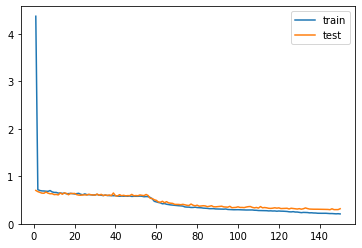

In [36]:
epochs = 150

plt.plot(range(1, epochs + 1), train_hist)
plt.plot(range(1, epochs + 1), test_hist)
plt.legend(['train', 'test'])

Use the part below if you wish to load a model rather than training it

In [ ]:
model = DTAModel(max_length_lig, max_length_prot)
model.to(device)
model.load_state_dict(torch.load('model3.pt'))
model.eval()


DTAModel(
  (drugmodel): DrugModel(
    (embedding): Embedding(62, 128)
    (conv1): Conv1d(128, 32, kernel_size=(4,), stride=(1,))
    (conv2): Conv1d(32, 64, kernel_size=(6,), stride=(1,))
    (conv3): Conv1d(64, 96, kernel_size=(8,), stride=(1,))
    (maxpooling): MaxPool1d(kernel_size=85, stride=85, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (lstm_model): DrugProtLSTM(
    (embedding): Embedding(25, 128)
    (LSTM): LSTM(128, 256, batch_first=True)
    (fc1): Linear(in_features=256, out_features=128, bias=True)
    (relu): ReLU()
  )
  (fc1): Linear(in_features=34176, out_features=1024, bias=True)
  (fc_lstm): Linear(in_features=224, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)

# Results

In [39]:
def calculate_predicted(model):
   model.eval()
   res = torch.tensor([]).to(device)
   truth = torch.tensor([]).to(device)
   with torch.no_grad():
      for i, data in enumerate(testloader):
         drug, prot, binding = data[0].long().to(device), data[1].long().to(device), data[2].unsqueeze(1).to(device).float()
         o = model(drug, prot)
         res = torch.cat([res, o], 0)
         truth = torch.cat([truth, binding], 0)
   return res, truth


In [40]:
preds, true = calculate_predicted(model)


In [43]:
def calculate_ci(preds, true, number):

  ci_score = 0
  pair = 0
  for i in range(1, number):
    print(i)
    for j in range(number):
      if true[i] > true[j]:
        ci_score += 1 * (preds[i] > preds[j]) + 0.5 * (preds[i] == preds[j])
        pair += 1
  return ci_score / pair

In [45]:
ci_score = calculate_ci(preds, true, len(true))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


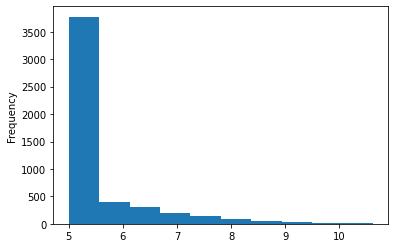

In [46]:
test_Y_df = pd.DataFrame(test_Y)
test_Y_df.stack().plot.hist()

In [47]:
print('CI score is: ', ci_score.item())
print('MSE score is: ', test(model, nn.MSELoss(reduction = 'sum'), verbose = False))

CI score is:  0.8651032447814941
MSE score is:  0.31472791035970055


In [48]:
def classify(true, preds, dataset):
  if dataset == 'kiba':
    threshold = 12.1
  else:
    threshold = 7
  
  clf_res = torch.zeros((len(preds), 1))
  clf_res[preds > threshold] = 1
  clf_res[preds <= threshold] = 0

  clf_true = torch.zeros((len(true), 1))
  clf_true[true > threshold] = 1
  clf_true[true <= threshold] = 0

  return clf_true, clf_res

In [61]:
clf_preds, clf_labels = classify(true, preds, 'davis')

clf_preds = clf_preds.cpu().numpy()
clf_labels = clf_labels.cpu().numpy()

In [62]:
def sens_spec(true, preds):
  tn, fp, fn, tp = confusion_matrix(true, preds).ravel()

  sens = (tp / (tp + fn))
  spec = (tn / (tn + fp))

  return sens, spec


In [63]:
print(classification_report(clf_labels, clf_preds))

sens, spec = sens_spec(clf_labels, clf_preds)
print('Specificiy: ', spec)
print('Sensitivity: ', sens)

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      4656
         1.0       0.57      0.66      0.61       354

    accuracy                           0.94      5010
   macro avg       0.77      0.81      0.79      5010
weighted avg       0.95      0.94      0.94      5010

Specificiy:  0.9619845360824743
Sensitivity:  0.6581920903954802
